In [1]:
%load_ext autoreload
%autoreload 2

# Figures for CVAE paper

In [ ]:
import os
import pandas as pd
import numpy as np
import itertools
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

jax.config.update("jax_platform_name", 'cpu')

from evoscaper.model.evaluation import calculate_distributional_overlap
from evoscaper.utils.preprocess import make_datetime_str, format_with_subscript
from evoscaper.utils.simulation import compute_analytics
from evoscaper.utils.visualise import create_network_inset, make_nx_weights
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json


sns.set_style('whitegrid')

2025-04-01 10:47:40.126974: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 10:47:40.136785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743504460.148391  883904 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743504460.151706  883904 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 10:47:40.163572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
top_write_dir = os.path.join('data', '18_figures_cvae', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

idx_output = -1


# Figure 1

In [4]:
# fn_1127 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# fn_0129 = 
# ds_1127 = pd.read_csv(fn_1127)
# ds_0129 = 

# Figure 2

In [5]:
def prep_analytics(a: dict):
    a.pop('RMSE')
    for k, v in a.items():
        a[k] = np.array(v)
    a['adaptation'] = calculate_adaptation(
        a['sensitivity'], a['precision'], alpha=2)
    return a

## Motifs generated in adaptation by best model

In [82]:
# fn_saves = 'data/01_cvae/2025_03_12__22_14_51/saves_2025_03_12__22_14_51_ds0129_a_hs32_nl3_KL2e4_cont01ts095pd3_lr1e3_teva97'
# dir_verify = 'data/02_cvae_verify/2025_03_13__21_21_52'
fn_saves = 'data/01_cvae/2025_03_20__14_23_17/saves_2025_03_20__14_23_17_ds0129_a2_hs32_nl3_KL2e4_cont01ts095pd3_lr1e3_teva98'
dir_verify = 'data/02_cvae_verify/2025_03_20__14_42_23'
dir_model = os.path.dirname(fn_saves)

hpos = load_json_as_dict(os.path.join(dir_model, 'hpos_all.json'))
ys = np.load(os.path.join(dir_verify, 'ys.npy'))
ts = np.load(os.path.join(dir_verify, 'ts.npy'))
fake_circuits = np.load(os.path.join(dir_verify, 'fake_circuits.npy'))
fake_circuits = fake_circuits.reshape(-1, fake_circuits.shape[-1])
sampled_cond = np.load(os.path.join(dir_verify, 'sampled_cond.npy'))
analytics = load_json_as_dict(os.path.join(dir_verify, 'analytics.json'))

analytics = prep_analytics(analytics)

<Axes: >

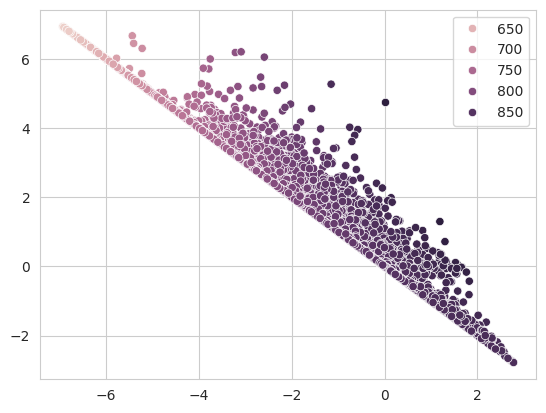

In [86]:
sns.scatterplot(x=analytics['Log sensitivity'][..., idx_output], y=analytics['Log precision'][..., idx_output], hue=analytics['adaptation'][..., idx_output])

## Top achievers generated by network (clusters)

In [273]:
idxs_adapt_og = np.where(((analytics['Log sensitivity'][..., idx_output] > 0) & (analytics['Log precision'][..., idx_output] > 0.5)))[0]
idxs_adapt = idxs_adapt_og[np.argsort(analytics['adaptation'][idxs_adapt_og, idx_output])[::-1]]

cols_e = list(set([hpos['x_type'] + '_' + '-'.join(sorted([str(i), str(j)])) for i, j in itertools.product(range(3), range(3))]))
cols_e_bins = [f'{c} bin' for c in cols_e]
df_plot = pd.DataFrame()
df_plot['Adaptation'] = analytics['adaptation'][idxs_adapt, idx_output]
df_plot[cols_e] = fake_circuits[idxs_adapt]

n_bins_energy = int(np.ceil(np.nanmax(np.abs(df_plot[cols_e]))))
d = df_plot[cols_e].melt(value_vars=cols_e, value_name='interaction_energy', var_name='interaction')
d['interaction_energy_bin'] = pd.cut(d['interaction_energy'], bins=n_bins_energy // 2).apply(lambda x: np.round(x.left, 2)).astype(float)
for c, c_bin in zip(cols_e, cols_e_bins):
    df_plot[c_bin] = d[d['interaction'] == c]['interaction_energy_bin'].values
del d
df_plot.sort_values(by=cols_e_bins, ascending=False, inplace=True)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
umap_res = reducer.fit_transform(df_plot[cols_e_bins if len(idxs_adapt) > 100 else cols_e].values)
df_plot['UMAP 1'] = umap_res[:, 0]
df_plot['UMAP 2'] = umap_res[:, 1]

len(idxs_adapt)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


57

In [ ]:
corr_diffs = jax.vmap(lambda x: jnp.sum(jnp.abs(x - df_plot[cols_e].values), axis=-1))(df_plot[cols_e].values) 
corr_diffs = corr_diffs / corr_diffs.max()

row_linkage = linkage(corr_diffs, method='ward')

# Assign clusters based on the 3rd level of hierarchical clustering
clusters = fcluster(row_linkage, t=4, criterion='maxclust')

df_plot['Cluster'] = clusters
n_clusters = df_plot['Cluster'].nunique()
n_clusters


/tmp/ipykernel_883904/850324101.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = linkage(corr_diffs, method='ward')


4

In [311]:
# min_cluster_size = 20 if len(idxs_adapt) > 1000 else 8
# min_samples = 15 if len(idxs_adapt) > 1000 else 2
# clusterer = hdbscan.HDBSCAN(
#     min_cluster_size=min_cluster_size, min_samples=min_samples)
# df_plot['Cluster'] = clusterer.fit_predict(df_plot[['UMAP 1', 'UMAP 2']])
# df_plot['Cluster'] = df_plot['Cluster'] + np.abs(df_plot['Cluster'].min()) + 1
# df_plot['Cluster'].nunique()

category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO
category.py:update():224: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. INFO


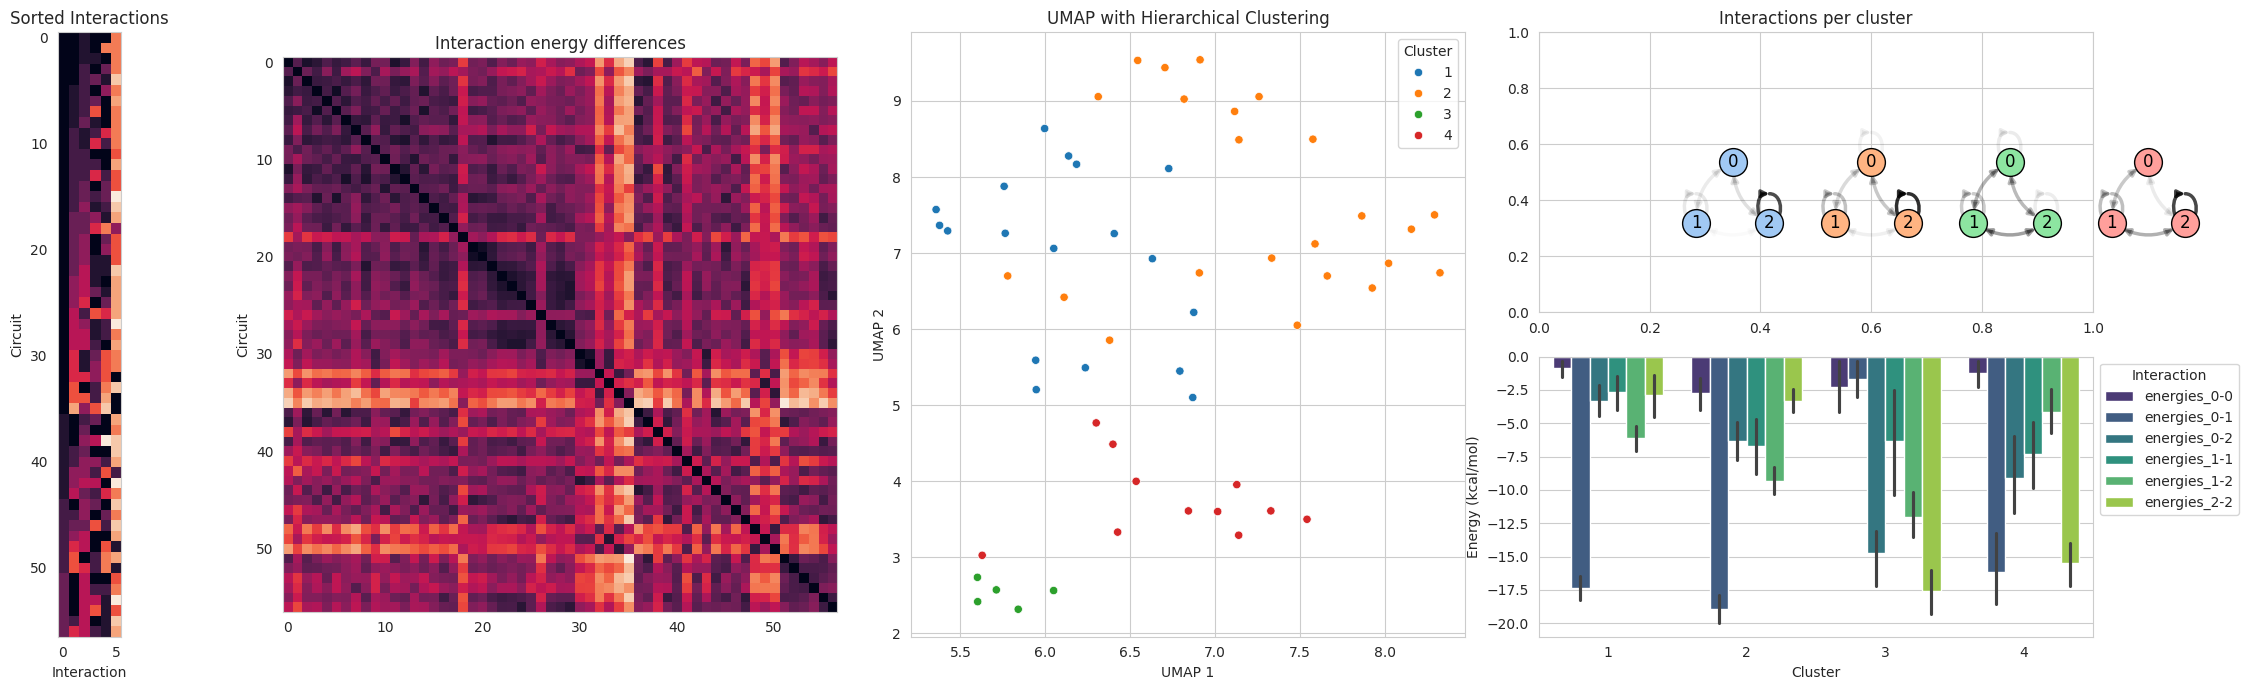

In [335]:
# Create figure with proper gridspec from the beginning
fig = plt.figure(figsize=(23, 7))
gs = fig.add_gridspec(2, 7) #, width_ratios=[1, 2, 2, 2, 2, 2, 2],
                    #   height_ratios=[2, 2, 2, 2, 2, ], hspace=0.2, wspace=0.2)

# Create axes using the gridspec directly
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[:, 1:3])
ax2 = fig.add_subplot(gs[:, 3:5])
ax3 = fig.add_subplot(gs[1, 5:])
ax4 = fig.add_subplot(gs[0, 5:])

# Group axes in a list for easier reference
axs = [ax0, ax1, ax2, ax3]

# Create plots on each axis
ax0.imshow(np.abs(df_plot.sort_values(by=cols_e_bins, ascending=False)[cols_e_bins].values) / np.max(np.abs(df_plot[cols_e])), cmap='rocket')
ax0.set_title('Sorted Interactions')
ax0.set_xlabel('Interaction')
ax0.set_ylabel('Circuit')
ax1.imshow(corr_diffs, cmap='rocket')
ax1.set_title('Interaction energy differences')
ax1.set_ylabel('Circuit')
ax0.grid(False)
ax1.grid(False)

g = sns.scatterplot(data=df_plot, x='UMAP 1', y='UMAP 2', hue='Cluster', #style='Cluster',
                palette='tab10', ax=ax2)
# sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
ax2.set_title('UMAP with Hierarchical Clustering')

g = sns.barplot(data=df_plot.melt(id_vars=['Cluster'], 
                              value_vars=cols_e, 
                              value_name='Energy (kcal/mol)', 
                              var_name='Interaction').sort_values('Interaction'),
            x='Cluster', y='Energy (kcal/mol)', hue='Interaction', 
            ax=ax3, palette='viridis')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

ax4.set_title('Interactions per cluster')
pos = np.concatenate([np.arange(n_clusters) / n_clusters, np.ones(n_clusters) * 0.1]).reshape(2, -1).T
colors = sns.color_palette('pastel', n_clusters).as_hex()
for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
    fake_circuits_cluster = df_plot[df_plot['Cluster']
                                    == c][cols_e].values
    w = np.median(fake_circuits_cluster, axis=0)
    create_network_inset(fig, ax4,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3, 
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)

plt.tight_layout()

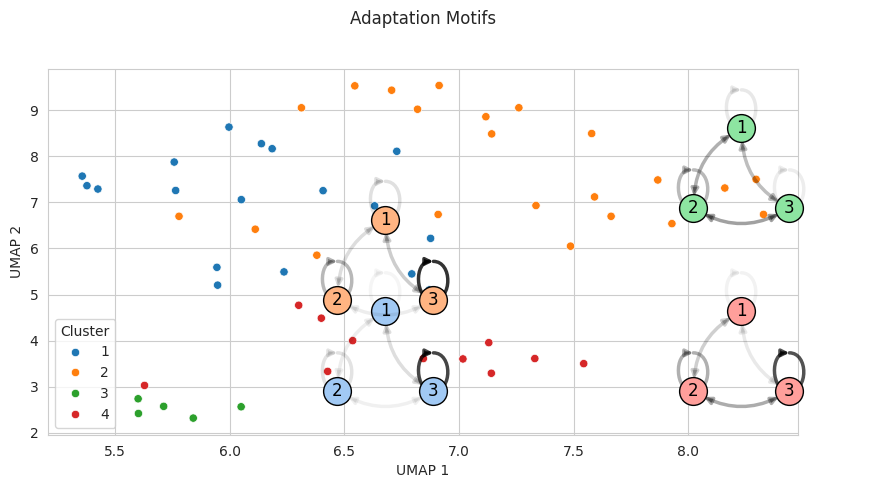

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.scatterplot(df_plot, x='UMAP 1', y='UMAP 2',
                hue='Cluster', palette='tab10')
colors = sns.color_palette('pastel', n_clusters).as_hex()
# colors = ['lightblue', 'orange', 'lightgreen', 'red', 'lightpurple']
pos = [[0.5, -0.1], [-0.18, -0.02], [0, 0.5], [0.25, 0.2], [0.55, 0.3]]
pos = np.concatenate([np.arange(n_clusters) / (n_clusters+1)-0.2, np.random.rand(n_clusters) * 0.5]).reshape(2, -1).T
pos = np.concatenate([np.repeat(np.arange(int(n_clusters / 2) + 1), repeats=2) / n_clusters * 1.9 + 0.1,
                      (np.repeat(np.arange(int(n_clusters / 2) + 1)[None, :], repeats=2, axis=0).flatten() / n_clusters - 0.1) 
                      ]).reshape(2, -1).T
for i, c in enumerate(sorted(df_plot['Cluster'].unique())):
    fake_circuits_cluster = df_plot[df_plot['Cluster']
                                    == c][cols_e].values
    w = fake_circuits_cluster.mean(axis=0)
    create_network_inset(fig, ax,
                         pos=pos[i],
                         width=0.7, height=0.7, edge_weights=make_nx_weights(w, n_nodes=3, 
                                                                             vmin=np.min(df_plot[cols_e]), vmax=np.max(df_plot[cols_e])),
                         node_color=colors[i], linewidth=2.5)
plt.title('Adaptation Motifs')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'motifs.png'),
            dpi=300, bbox_inches='tight', transparent=True)


## Supplementary 

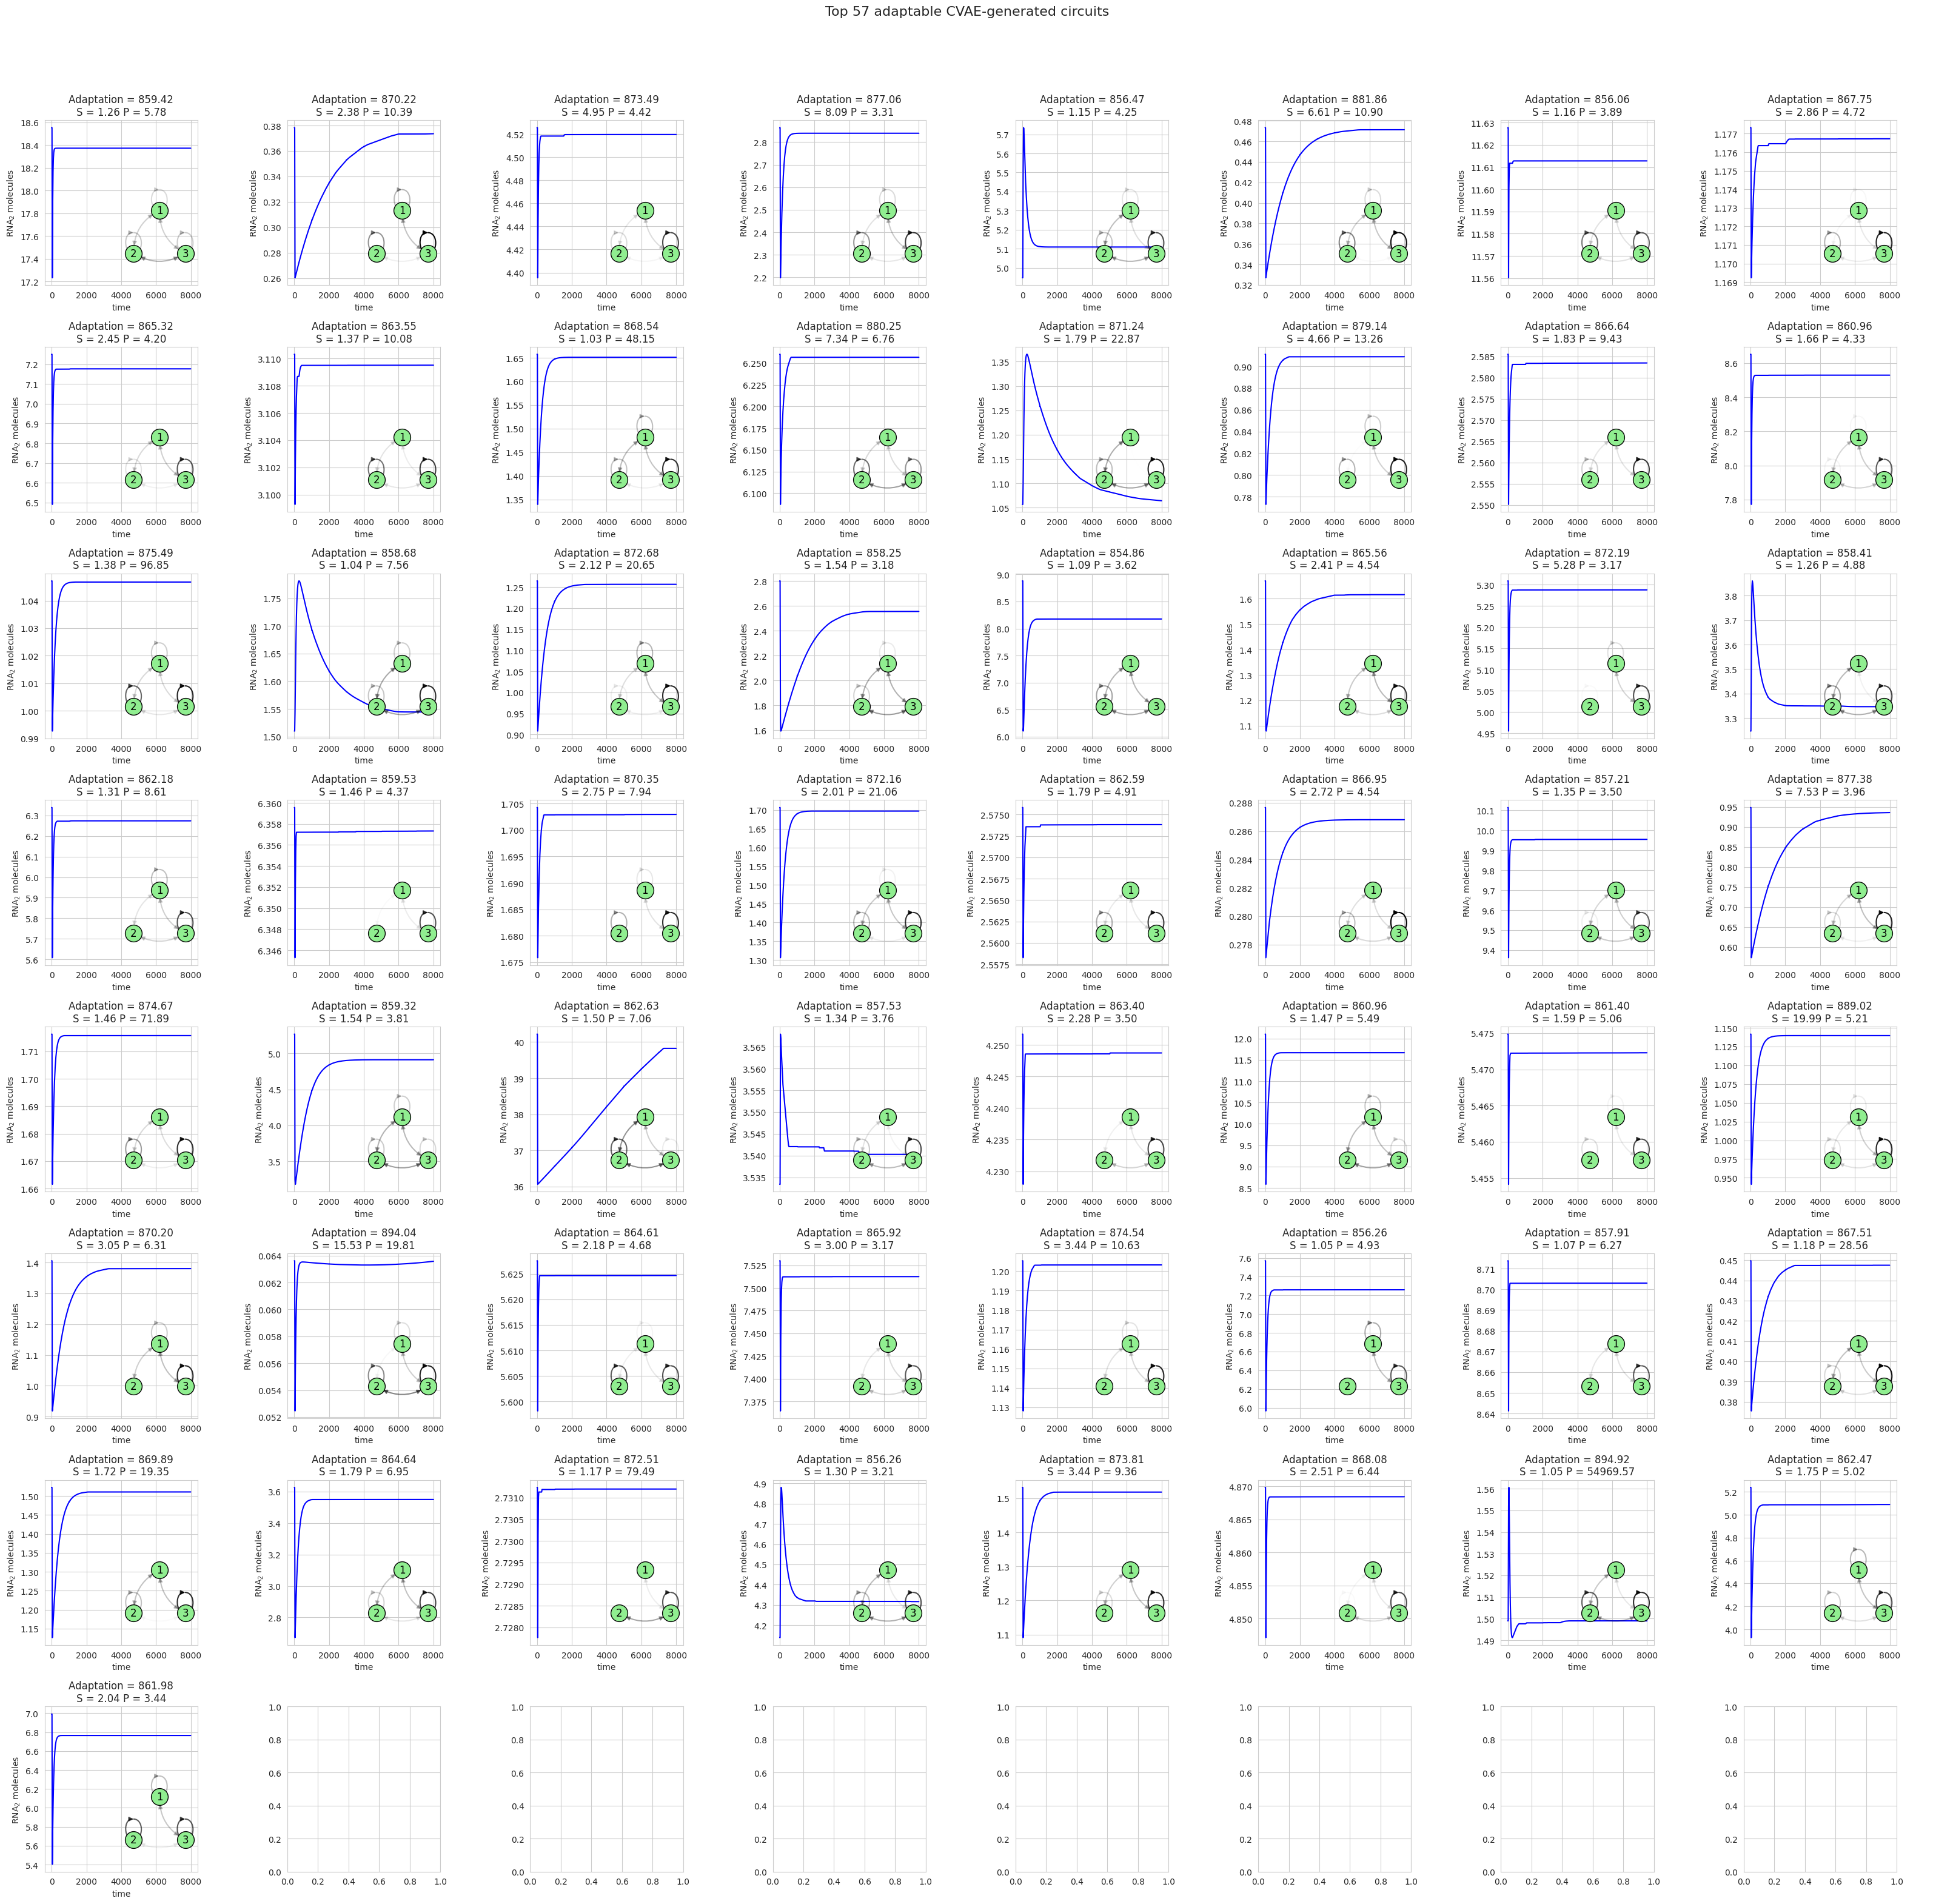

In [ ]:
idxs_adapt = idxs_adapt_og[df_plot.reset_index().sort_values(by=cols_e_bins, ascending=False)['index'].values]

n_top = np.min([64, len(idxs_adapt)])

# a = np.where(np.isfinite(analytics['adaptation']) & (
#     analytics['overshoot'] / analytics['initial_steady_states'] > 0.05) & (
#         analytics['response_time'] < (0.9 * analytics['response_time'].max())
#         ) & (analytics['initial_steady_states'] > 0), analytics['adaptation'], 0)
a = analytics['adaptation']

nrows = int(np.ceil(np.sqrt(n_top)))
ncols = int(np.ceil(np.sqrt(n_top)))
# ncols = int(np.ceil(n_top / nrows))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * 4, nrows * 4))

# fake_circuits = df_plot[cols_e].values
t_plotmax = int(30000*0.8)
for i, idx in enumerate(idxs_adapt[:n_top]):
    # ax = axs[i // ncols, i % ncols]
    ax = axs.flat[i]
    ax.plot(ts, ys[idx, :, idx_output].T, color='b')
    
    w = fake_circuits[idx]
    create_network_inset(fig, ax, width=0.9, height=0.9, edge_weights=make_nx_weights(
        w, n_nodes=3, vmin=fake_circuits[idxs_adapt].min(), vmax=fake_circuits[idxs_adapt].max()), node_color='lightgreen')
    ax.set_title(f'Adaptation = {a[idx, idx_output]:.2f}\nS = {analytics["sensitivity"][idx, idx_output]:.2f} P = {analytics["precision"][idx, idx_output]:.2f}')
    ax.set_xlabel('time')
    ax.set_ylabel(f'{format_with_subscript("RNA_2")} molecules')

plt.suptitle(f'Top {n_top} adaptable CVAE-generated circuits', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir,
            'best_performing_circuits_networks.png'), dpi=300, bbox_inches='tight', transparent=True)

# w, fake_circuits.reshape(np.prod(fake_circuits.shape[:-1]), -1)[idxs_adapt] #, analytics['sensitivity'][idx_max, idx_output]

# Figure 3

In [ ]:
def calc_overlaps(analytic):
    """ Calculate for 1 sample.
    For analytic, shape is (n_conditions, n_evaluated_per_sample)
    """
    kde = calculate_distributional_overlap(analytic, dist_type='kde')
    overlaps_nodiag = kde[~np.eye(kde.shape[0], dtype=bool)
                          ].reshape(kde.shape[0], -1)
    kde_overlaps = {
        'max': overlaps_nodiag.max(axis=1),
        'min': overlaps_nodiag.min(axis=1),
        'mean': overlaps_nodiag.mean(axis=1),
        'std': overlaps_nodiag.std(axis=1)}
    return kde_overlaps


def stitch_analytics(dir_src, overwrite=False):
    dir_b = os.path.join(dir_src, 'batch_results')
    if os.path.exists(dir_b):
        analytics = {}
        for l in os.listdir(dir_b):
            fn_a = os.path.join(dir_b, l, 'analytics.json')
            if os.path.exists(fn_a):
                analytics_batch = load_json_as_dict(fn_a)
                for k, v in analytics_batch.items():
                    if k not in analytics.keys():
                        analytics[k] = []
                    analytics[k].extend(v)
        if overwrite:
            write_json(analytics, os.path.join(dir_src, 'analytics.json'))
        return analytics
    else:
        raise ValueError(
            f'No batch_results folder in {dir_src} to stitch analytics from.'
        )



## Dataset sizes

In [ ]:
dir_ds_hpo = 'data/cvae_multi/2025_03_03__21_33_13'
dir_ds_sim = 'data/cvae_multi/2025_03_09__15_19_54'
df_hpos_ds = pd.read_json(os.path.join(dir_ds_hpo, 'df_hpos.json'))
analytics_ds = load_json_as_dict(os.path.join(dir_ds_sim, 'analytics.json'))
fake_circuits_ds = np.load(os.path.join(dir_ds_sim, 'fake_circuits.npy'))
sampled_cond_ds = np.load(os.path.join(dir_ds_sim, 'sampled_cond.npy'))

if len(analytics_ds.keys()) == 0:
    ys = np.load(os.path.join(dir_ds_sim, 'ys.npy'))
    ts = np.load(os.path.join(dir_ds_sim, 'ts.npy'))
    signal_onehot = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0])
    analytics_ds = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
        ys.shape[-1]), signal_onehot=signal_onehot))(ys)
    write_json(analytics_ds, os.path.join(dir_ds_sim, 'analytics.json'))

idx_output = -1
analytics_ds.pop('RMSE')
for k, v in analytics_ds.items():
    analytics_ds[k] = np.array(v)
    
analytics_ds['adaptation'] = calculate_adaptation(
    analytics_ds['sensitivity'], analytics_ds['precision'], alpha=2
)

In [ ]:
df_hpos_succ = df_hpos_ds[df_hpos_ds['run_successful']]

objective_col = df_hpos_ds['objective_col'].iloc[0]
objective_chosen = 'adaptation'
n_categories = df_hpos_succ['eval_n_categories'].iloc[0]
df_hpos_ds['total_ds_max'].unique(), df_hpos_ds['seed_dataset'].unique()

(array([5000000,     300,     700,    1000,    5000,   10000,   50000,
         100000,  500000, 1000000]),
 array([1, 2, 3, 4, 5]))

In [90]:
sampled_cond_ds.shape #.reshape(25, -1, 2).shape

(82, 25, 200, 2)

In [57]:
analytics_ds['adaptation'][..., idx_output].reshape(len(df_hpos_succ), np.power(n_categories, len(objective_col)), -1).shape

(82, 25, 200)

<Axes: ylabel='Density'>

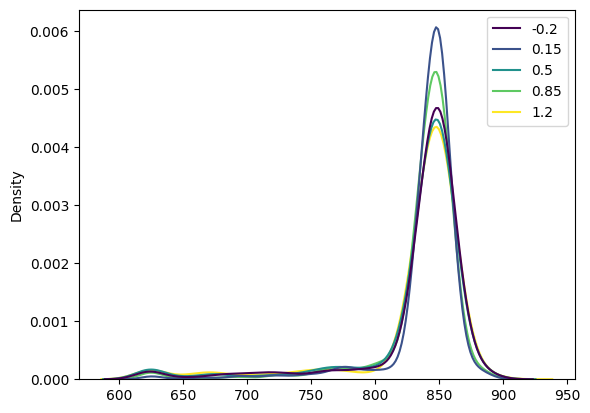

In [100]:
sns.kdeplot(x=analytics_ds['adaptation'][..., idx_output].reshape(len(df_hpos_succ), np.power(n_categories, len(objective_col)), -1)[0].flatten(),
            hue=sampled_cond_ds[0][..., 0].flatten().round(2),
            #  bins=120)
            palette='viridis')

(array([5000000,     300,     700,    1000,    5000,   10000,   50000,
         100000,  500000, 1000000]),
 array([1, 2, 3, 4, 5]))

In [ ]:
df_hpos_succ = df_hpos_ds[df_hpos_ds['run_successful']]
df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(
    lambda x: np.max([y for y in x['mean'] if y is not None])
)
eval_n_to_sample = df_hpos_succ['eval_n_to_sample'].values[0]

n_categories = 10
a = analytics_ds[objective_chosen][..., idx_output].flatten()
for k in ['mean', 'std', 'min', 'max']:
    df_hpos_succ.loc[:, f'KDE {objective_chosen} {k}'] = np.nan
kde_overlaps_all = np.zeros((len(df_hpos_succ), n_categories))
for i, (ir, r) in enumerate(df_hpos_succ.iterrows()):
    kde_overlaps = calc_overlaps(
        analytic=a[i*eval_n_to_sample:(i+1)*eval_n_to_sample].reshape(n_categories, -1),
        # analytic=a.reshape(
        #     len(df_hpos_succ), sampled_cond.shape[0] // len(df_hpos_succ), -1)[i],
        # sampled_cond=sampled_cond.reshape(
        #     len(df_hpos_succ),
        #     sampled_cond.shape[0] // len(df_hpos_succ), -1, sampled_cond.shape[-1])[i]
    )
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} min'] = kde_overlaps['min'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} max'] = kde_overlaps['max'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} mean'] = kde_overlaps['mean'].mean()
    df_hpos_succ.loc[ir, f'KDE {objective_chosen} std'] = kde_overlaps['std'].mean()
    kde_overlaps_all[i] = kde_overlaps['mean']
    # print(r['temperature'], r['seed_train'], kde_overlaps['min'].mean(), kde_overlaps['max'].mean())

In [ ]:
sns.scatterplot(data=d_plot,  # [d_plot['KDE adaptation mean'] > 0.8],
                x='Temperature', y='KDE adaptation mean',
                hue='Seed',
                palette='crest',
                alpha=0.5, s=60)
sns.lineplot(x=np.repeat(df_hpos_succ['temperature'].values, repeats=n_categories),
             y=kde_overlaps_all.flatten(),
             palette='crest', alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature', fontsize=18)
# plt.xlabel('Temperature', fontsize=14)
# plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])

(np.float64(0.07844413931711611), np.float64(0.8379569402641905))

## Contrastive loss

## Stitch together re-started

In [5]:
# dir_1 = os.path.join('data', 'cvae_multi', '2025_03_27__16_33_11')
# dir_2 = os.path.join('data', 'cvae_multi', '2025_03_27__22_02_47')
# fn_hpos_1 = os.path.join(dir_1, 'df_hpos.json')
# fn_hpos_2 = os.path.join(dir_2, 'df_hpos.json')
# df_hpos_1 = pd.read_json(fn_hpos_1)
# df_hpos_2 = pd.read_json(fn_hpos_2)
# df_hpos = pd.concat([df_hpos_1.iloc[:df_hpos_2.index[0]], df_hpos_2])
# df_hpos['filename_saved_model'] = df_hpos['filename_saved_model'].str.replace(
#     dir_1, dir_2)
# df_hpos.to_json(fn_hpos_2)
# df_hpos.to_csv(
#     os.path.join(dir_2, 'df_hpos.csv')
# )

# d = os.path.join(dir_2, 'batch_results')
# for l in os.listdir(d):
#     ll = 'batch_' + str(int(l.split('_')[-1]) + 4)
#     os.rename(os.path.join(d, l), os.path.join(d, ll))

# xx_1 = np.load('data/cvae_multi/2025_03_29__15_05_30/sampled_cond.npy')
# xx_2 = np.load('data/cvae_multi/2025_03_27__22_02_47/sampled_cond_og.npy')

# xx_3 = np.concatenate(
#     [xx_1, xx_2], axis=0
# )
# print(len(xx_1), len(xx_2), len(xx_3))

# np.save('data/cvae_multi/2025_03_27__22_02_47/sampled_cond.npy', xx_3)


## Look at new contrastive loss

In [5]:
dir_contloss = 'data/cvae_multi/2025_03_27__22_02_47'
fn_df_hpos = os.path.join(dir_contloss, 'df_hpos.json')
fn_analytics = os.path.join(dir_contloss, 'analytics.json')
df_hpos = pd.read_json(fn_df_hpos)

analytics = load_json_as_dict(fn_analytics)
fake_circuits = np.load(os.path.join(dir_contloss, 'fake_circuits.npy'))
sampled_cond = np.load(os.path.join(dir_contloss, 'sampled_cond.npy'))

# Stitch batch analytics if necessary
if len(analytics['sensitivity']) != len(fake_circuits):
    analytics = stitch_analytics(dir_contloss)

objective_chosen = 'adaptation'

analytics.pop('RMSE')
for k, v in analytics.items():
    analytics[k] = np.array(v)
    
analytics['adaptation'] = calculate_adaptation(
    analytics['sensitivity'], analytics['precision'], alpha=2
)

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [ ]:
n_categories = 10
a = analytics[objective_chosen][..., idx_output].flatten()
kde_overlaps_all = np.ones((len(df_hpos), n_categories)) * np.nan
eval_n_to_sample = df_hpos['eval_n_to_sample'].values[0]
if f'KDE {objective_chosen} min' not in df_hpos.columns:
    df_hpos.loc[:, f'KDE {objective_chosen} min'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} max'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} mean'] = np.nan
    df_hpos.loc[:, f'KDE {objective_chosen} std'] = np.nan

    for i, (ir, r) in enumerate(df_hpos[df_hpos['run_successful']].iterrows()):
        if not r['run_successful']:
            continue
        kde_overlaps = calc_overlaps(
            analytic=a[i*eval_n_to_sample:(i+1) *
                       eval_n_to_sample].reshape(n_categories, -1),
        )
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} min'] = kde_overlaps['min'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} max'] = kde_overlaps['max'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} mean'] = kde_overlaps['mean'].mean()
        df_hpos.loc[ir,
                    f'KDE {objective_chosen} std'] = kde_overlaps['std'].mean()
        kde_overlaps_all[i] = kde_overlaps['mean']
        # print(r['temperature'], r['seed_train'], kde_overlaps['min'].mean(), kde_overlaps['max'].mean())

    write_json(df_hpos, fn_df_hpos)

In [7]:
df_hpos_succ = df_hpos[df_hpos['run_successful']]
df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(
    lambda x: np.max([y for y in x['mean'] if y is not None])
)


/tmp/ipykernel_543231/682999503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hpos_succ['Distribution overlap'] = df_hpos_succ['Overlap adaptation'].apply(


In [8]:
d_plot = pd.DataFrame()
d_plot[objective_chosen] = analytics[objective_chosen][..., idx_output].flatten()
d_plot['Prompted condition'] = sampled_cond[..., 0].flatten().round(2)
d_plot['Temperature'] = np.repeat(df_hpos_succ['temperature'], repeats=eval_n_to_sample).values.round(2)
d_plot['Seed'] = np.repeat(df_hpos_succ['seed_train'], repeats=eval_n_to_sample).values.round(2)
for k in ['Distribution overlap', f'KDE {objective_chosen} min', f'KDE {objective_chosen} max',
          f'KDE {objective_chosen} mean', f'KDE {objective_chosen} std']:
    d_plot[k] = np.repeat(df_hpos_succ[k], repeats=eval_n_to_sample).values.round(2)



Text(0.5, 0.98, 'Objective: adaptation')

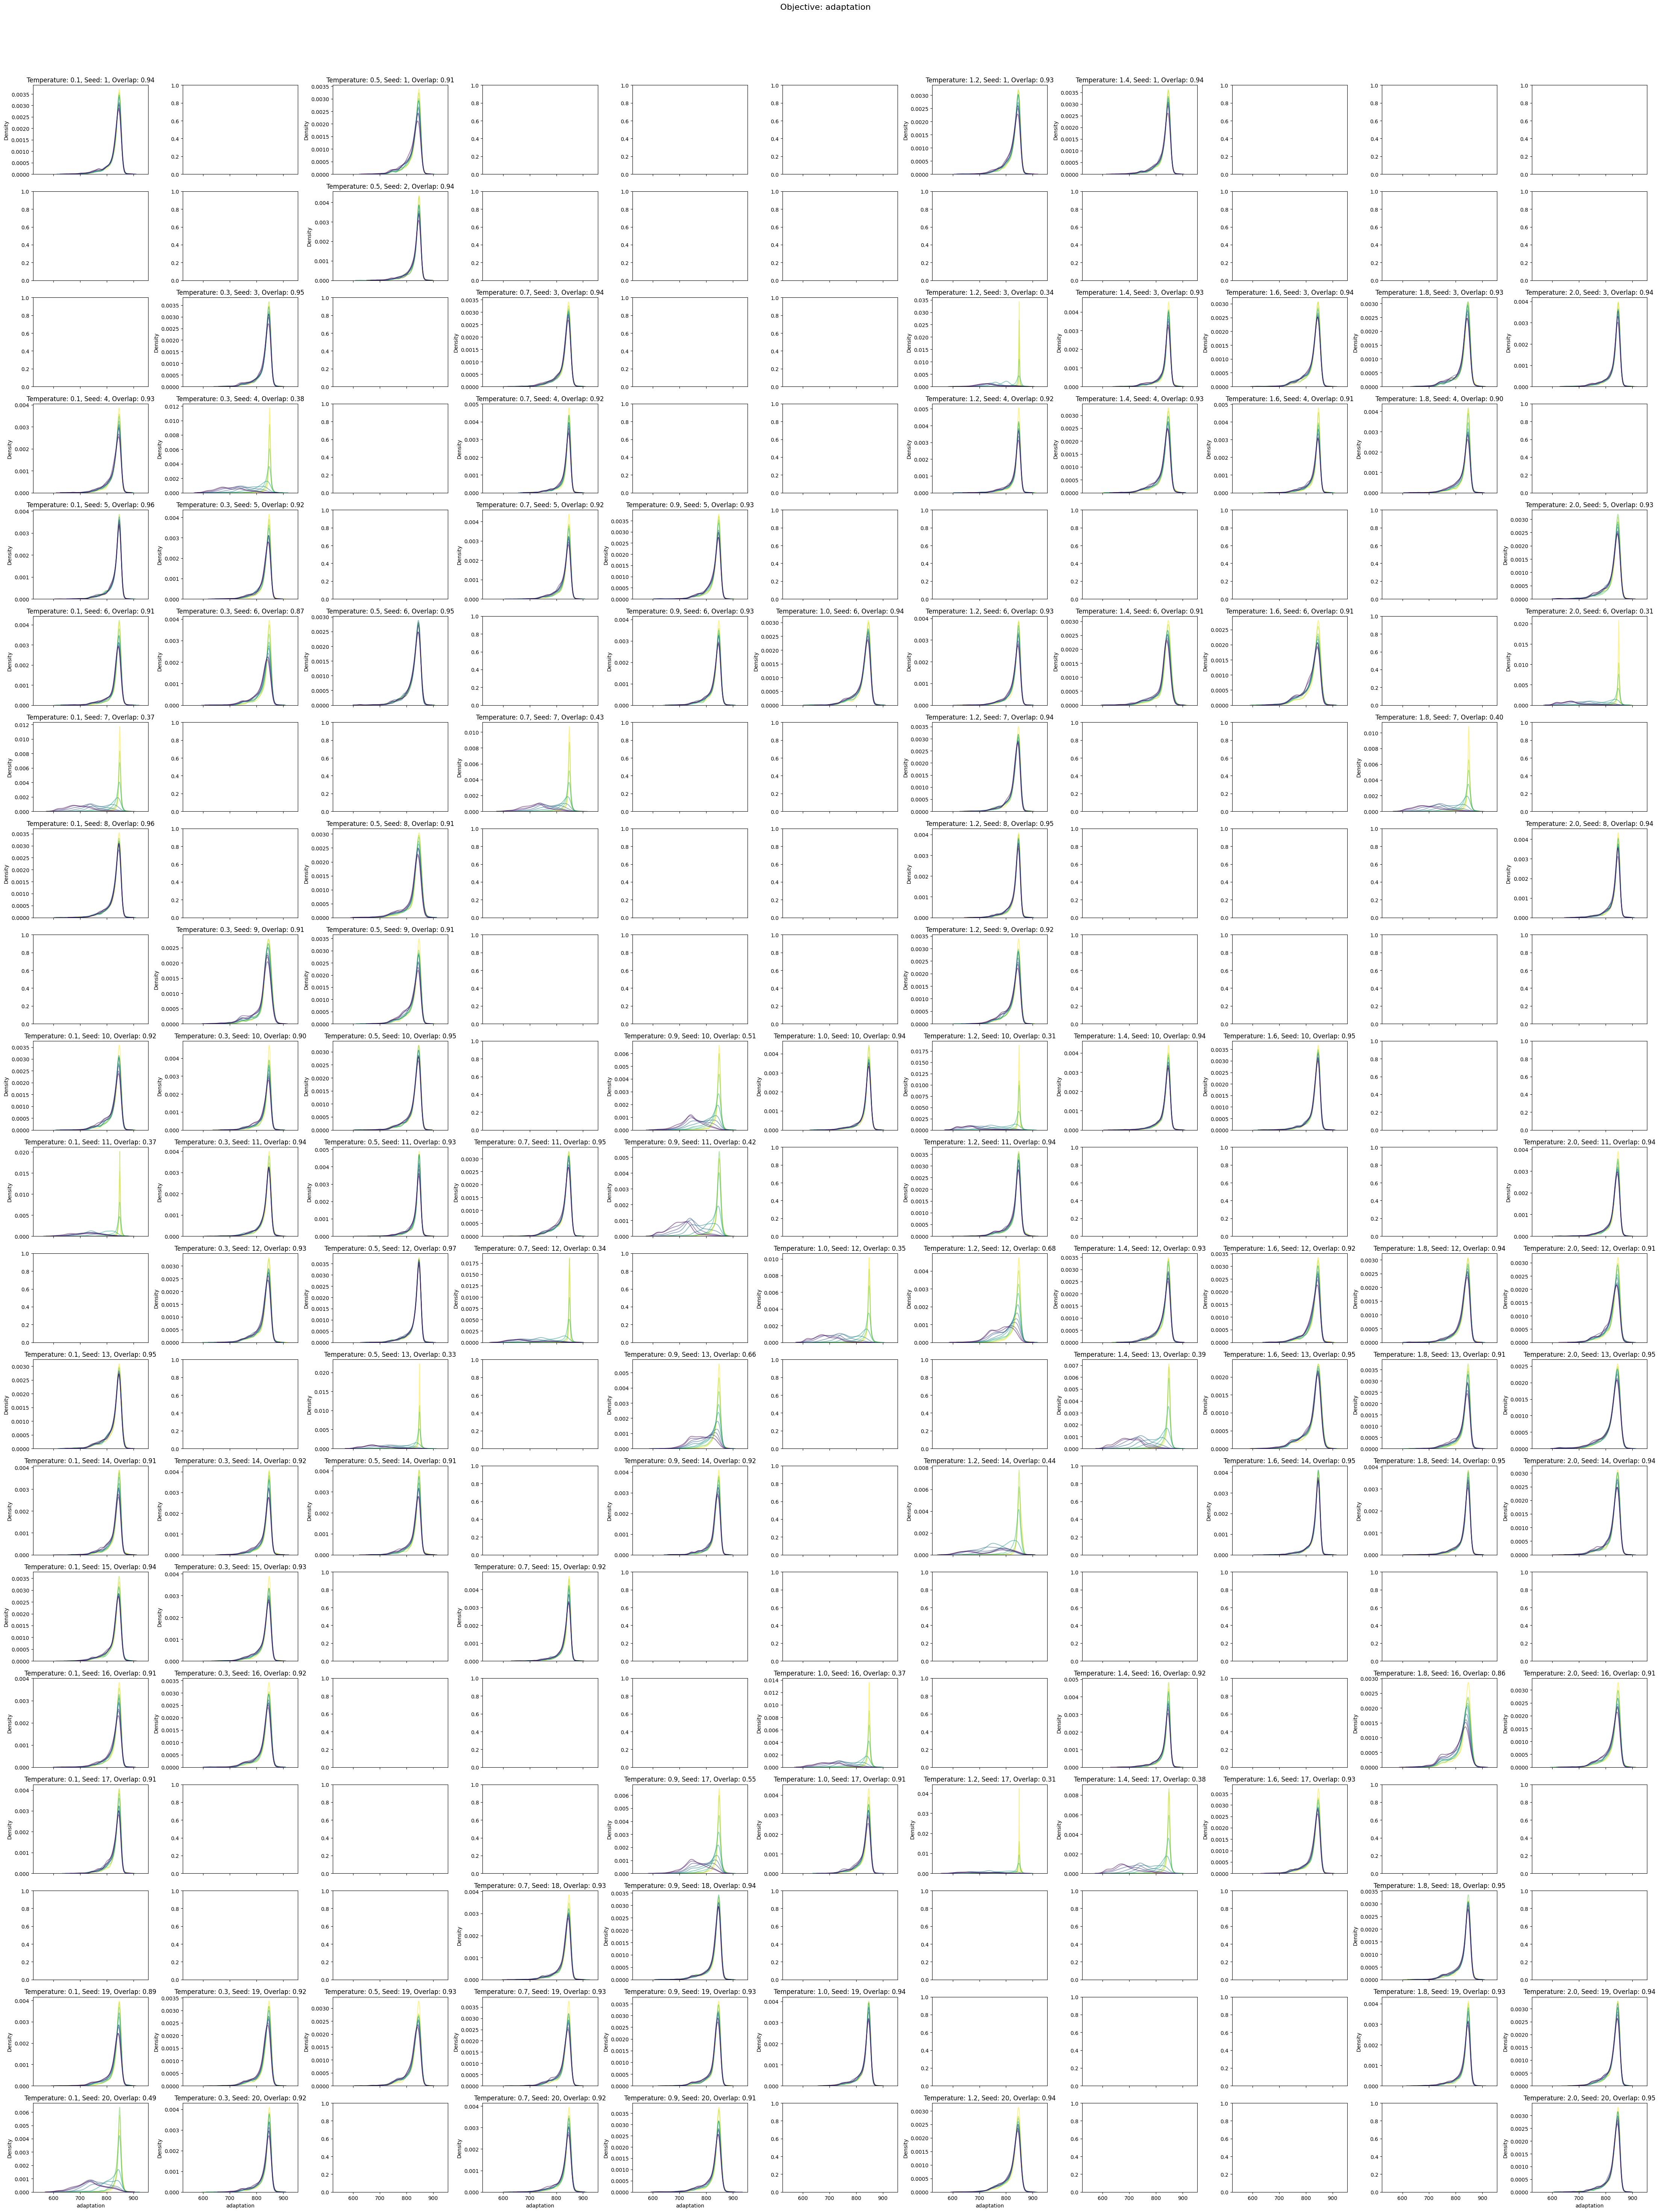

In [ ]:
# sns.kdeplot(d_plot, x=objective_chosen, hue='Prompted condition')
ncols = d_plot['Temperature'].nunique()
nrows = d_plot['Seed'].nunique()
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 1*nrows), sharey=False, sharex=True)
for i, t in enumerate(sorted(d_plot['Temperature'].unique())):
    for j, s in enumerate(sorted(d_plot['Seed'].unique())):
        filt = (d_plot['Temperature'] == t) & (d_plot['Seed'] == s)
        if d_plot[filt].shape[0] == 0:
            continue
        sns.kdeplot(d_plot[filt], x=objective_chosen, hue='Prompted condition', # bins=50, 
            palette='viridis', ax=axs[j, i], alpha=0.5, legend=False if i == 0 else False)
        axs[j, i].set_title(f'Temperature: {t:.1f}, Seed: {s}, Overlap: {d_plot[filt]["KDE adaptation mean"].values[0]:.2f}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(f'Objective: {objective_chosen}', fontsize=16)


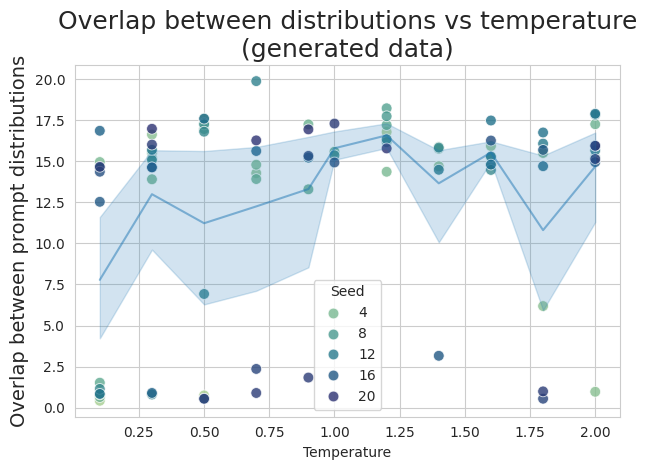

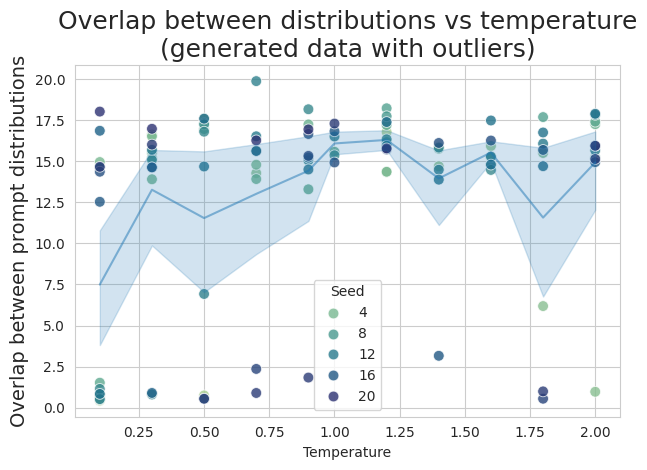

In [ ]:
if 'kl_div_ave' in df_hpos.columns:
    df_hpos['kl_div_max'] = df_hpos['kl_div_ave'].apply(lambda x: np.nanmax(list(x.values())) if type(x) != str else np.nan)
    df_hpos['kl_div_max'] = df_hpos['kl_div_max'].apply(lambda x: 1/x)
    df_hpos['kl_div_means'] = df_hpos['kl_div_ave'].apply(lambda x: np.nanmean(list(x.values())) if type(x) != str else np.nan)
    df_hpos['kl_div_means'] = df_hpos['kl_div_means'].apply(lambda x: 1/x)

df_hpos2 = df_hpos[['temperature', 'seed_train', 'KDE adaptation mean', 'kl_div_max', 'kl_div_means']].rename(columns={'temperature': 'Temperature', 'seed_train': 'Seed'})
sns.set_style('whitegrid')
sns.scatterplot(data=df_hpos2[df_hpos2['KDE adaptation mean'] > 0.8],
                x='Temperature', y='kl_div_means',
                hue='Seed', palette='crest', alpha=0.8, s=60)
sns.lineplot(data=df_hpos2[df_hpos2['KDE adaptation mean'] > 0.8],
             x='Temperature', y='kl_div_means', 
             alpha=0.5)
# sns.lineplot(x=np.repeat(df_hpos_succ['temperature'].values, repeats=n_categories),
#              y=kde_overlaps_all[df_hpos_succ.index].flatten(),
#              palette='crest', alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature\n(generated data)', fontsize=18)
plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temperature_fakec.png'),
            dpi=300, bbox_inches='tight', transparent=True)

plt.figure()
sns.scatterplot(data=df_hpos2, #[df_hpos2['KDE adaptation mean'] > 0.8],
                x='Temperature', y='kl_div_means',
                hue='Seed', palette='crest', alpha=0.8, s=60)
sns.lineplot(data=df_hpos2, #[df_hpos2['KDE adaptation mean'] > 0.8],
             x='Temperature', y='kl_div_means', 
             alpha=0.5)
plt.legend(title='Seed')
plt.title(f'Overlap between distributions vs temperature\n(generated data with outliers)', fontsize=18)
plt.ylabel('Overlap between prompt distributions', fontsize=14)
plt.tight_layout()  # rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'overlap_vs_temperature_fakec_woutliers.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Figure 4